In [1]:
import pandas as pd
import pytz
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
def pre_processing(file):
    #file inladen
    df = pd.read_csv(file)

    #omzetten tijden
    gmt_tz = pytz.timezone("GMT")
    pst_tz = pytz.timezone("US/Pacific")

    df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')

    df['connectionTime'] = df['connectionTime'].dt.tz_convert(pst_tz)
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(pst_tz)
    df['doneChargingTime'] = df['doneChargingTime'].dt.tz_convert(pst_tz)
    
    df['stayTime'] = df['disconnectTime'] - df['connectionTime']
    df.loc[df['stayTime'] < pd.Timedelta(0), 'stayTime'] += pd.Timedelta(hours=24) 
    df['chargeTime'] = df['doneChargingTime'] - df['connectionTime']
    df.loc[df['chargeTime'] < pd.Timedelta(0), 'chargeTime'] += pd.Timedelta(hours=24)
    
    df['LoadDone'] = df['kWhDelivered'] / ((df['chargeTime']).dt.total_seconds() / 3600)
    df['LoadDisc'] = df['kWhDelivered'] / ((df['stayTime']).dt.total_seconds() / 3600)


    # df['LoadDone'] = df['kWhDelivered'] / ((df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600)
    # df['LoadDisc'] = df['kWhDelivered'] / ((df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600)

    df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered', 'LoadDone', 'doneChargingTime', 'LoadDisc'])

    return df

def plotter(file, choice):
    minutes_in_day = 24 * 60
    energy_per_minute = np.zeros(minutes_in_day)
    count_per_minute = np.zeros(minutes_in_day)
    
    for _, row in file.iterrows():
        connection = row['connectionTime']
        done = row['doneChargingTime']
        disconnection = row['disconnectTime']
        
        if choice == 'done':
            end = done
            energy = row['LoadDone']
            duration_minutes = int((row['chargeTime']).total_seconds() / 60)
        elif choice == 'disc':
            end = disconnection
            energy = row['LoadDisc']
            duration_minutes = int((row['stayTime']).total_seconds() / 60)
        start = connection
        
        # if end <= start:
        #     continue  # Skip invalid sessions

        #duration_minutes = int((end - start).total_seconds() / 60)

        for i in range(duration_minutes):
            minute_time = start + timedelta(minutes=i)
            
            #minute_of_day = minute_time.hour * 60 + minute_time.minute
            minute_of_day = int(minute_time.hour * 60 + minute_time.minute) % (24 * 60)  # Ensures it stays within [0, 1440)
            #rint(minute_of_day)
            energy_per_minute[minute_of_day] += energy
            count_per_minute[minute_of_day] += 1
    
    return energy_per_minute/210


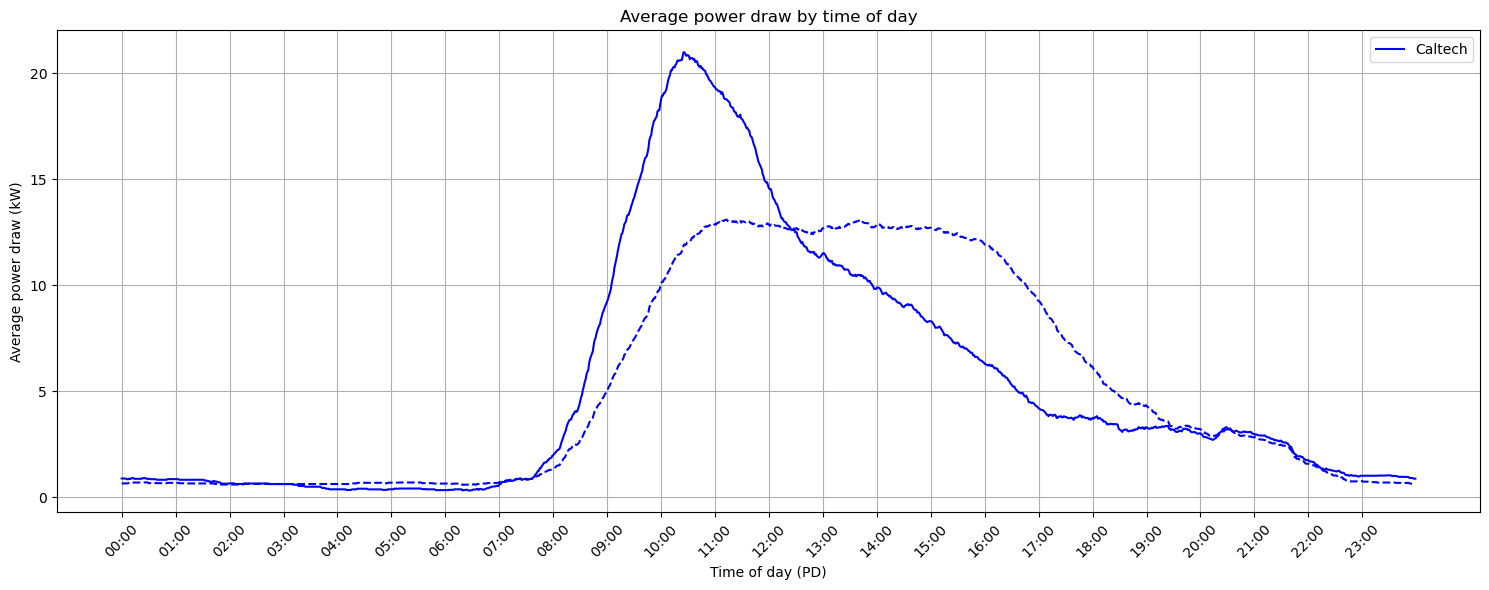

In [3]:
energy_file11 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"),'done')
energy_file12 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"),'disc')

# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(energy_file11, color='blue', label='Caltech', linewidth=1.5)
plt.plot(energy_file12, linestyle='--', color='blue', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of day (PD)")
plt.ylabel("Average power draw (kW)")
plt.title("Average power draw by time of day")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_15308\3905233878.py:3: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\chris\AppData\Local\Temp\ipykernel_15308\3905233878.py:3: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


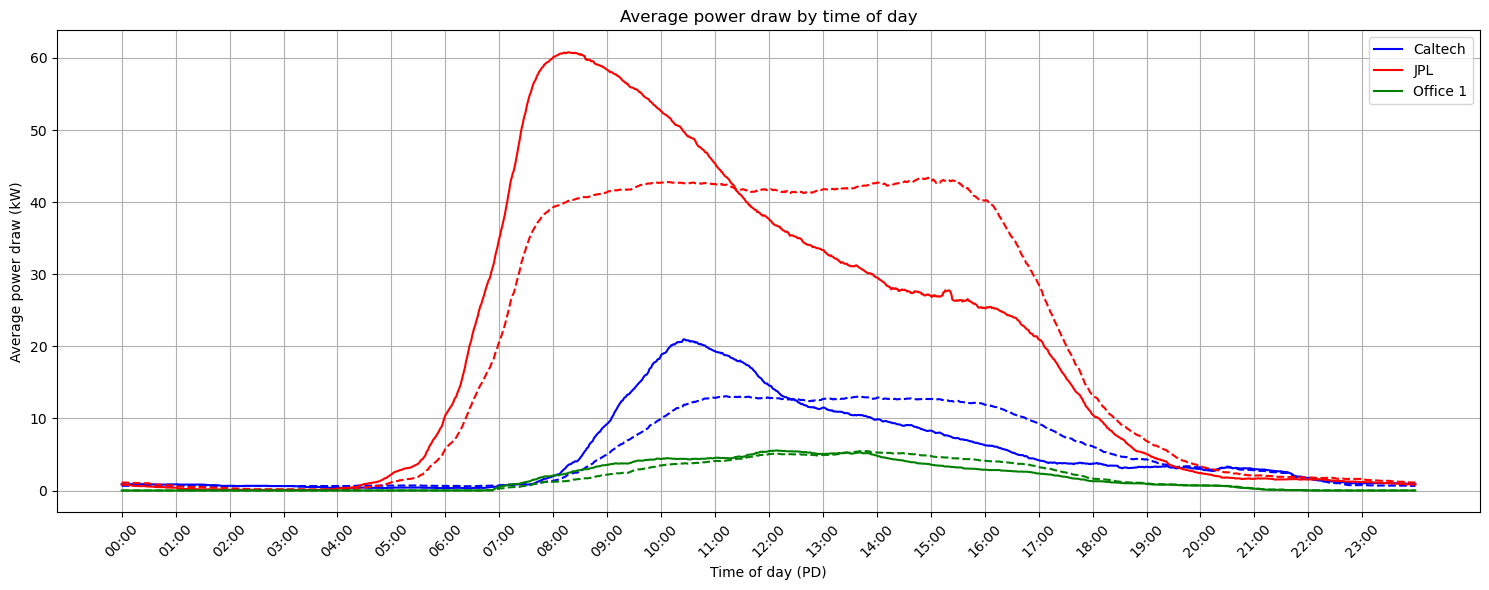

In [4]:
#display(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"))
energy_file11 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"),'done')
energy_file12 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"),'disc')
energy_file21 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 jpl.csv"),'done') 
energy_file22 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 jpl.csv"),'disc')
energy_file31 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 office1.csv"), 'done')
energy_file32 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 office1.csv"), 'disc')

# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(energy_file11, color='blue', label='Caltech', linewidth=1.5)
plt.plot(energy_file12, linestyle='--', color='blue', linewidth=1.5)
plt.plot(energy_file21, color='red', label='JPL', linewidth=1.5)
plt.plot(energy_file22, linestyle='--', color='red', linewidth=1.5)
plt.plot(energy_file31, color='green', label='Office 1', linewidth=1.5)
plt.plot(energy_file32, linestyle='--', color='green', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of day (PD)")
plt.ylabel("Average power draw (kW)")
plt.title("Average power draw by time of day")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
pred_data =pd.read_csv('Processed data/db_cleaned_with_predictions.csv')
pred_data['stayTime'] = pred_data['Actual_DisconnectTime'] - pred_data['ConnectionTime']
pred_data['predStayTime'] = pred_data['Predicted_DisconnectTime_NN'] - pred_data['ConnectionTime']
pred_data['chargeTime'] = pred_data['doneChargingTime'] - pred_data['ConnectionTime']

pred_data.loc[pred_data['stayTime'] < 0, 'stayTime'] += 24 
pred_data.loc[pred_data['predStayTime'] < 0, 'predStayTime'] += 24 
pred_data.loc[pred_data['chargeTime'] < 0, 'chargeTime'] += 24 
pred_data.loc[pred_data['chargeTime'] > pred_data['stayTime'], 'chargeTime'] = pred_data['stayTime']

pred_data['LoadDisc'] = pred_data['Actual_kWhDelivered'] / pred_data['stayTime'] 
pred_data['LoadDone'] = pred_data['Actual_kWhDelivered'] / pred_data['chargeTime'] 
pred_data['LoadPred'] = pred_data['Predicted_kWhDelivered_NN'] / pred_data['predStayTime'] 

jpl_data_pred = pred_data[pred_data['SiteID']==1]
cal_data_pred = pred_data[pred_data['SiteID']==2]
of1_data_pred = pred_data[pred_data['SiteID']==19]
cal_data_pred.head(5)

,ConnectionTime,SiteID,doneChargingTime,Actual_DisconnectTime,Actual_kWhDelivered,Predicted_DisconnectTime_NN,Predicted_kWhDelivered_NN,stayTime,predStayTime,chargeTime,LoadDisc,LoadDone,LoadPred
1,8.920278,2.0,11.085278,17.585278,12.925,16.556215,13.575590,8.665000,7.635937,2.165000,1.491633,5.969977,1.777855
5,15.433889,2.0,16.173611,17.544444,2.063,17.780478,8.321440,2.110556,2.346589,0.739722,0.977468,2.788885,3.546186
8,10.040833,2.0,11.986944,18.296667,5.884,16.325185,6.098199,8.255833,6.284352,1.946111,0.712708,3.023466,0.970378
9,8.213056,2.0,10.065278,18.178333,8.087,14.375643,13.304182,9.965278,6.162588,1.852222,0.811518,4.366107,2.158863
10,15.821389,2.0,17.074444,17.076944,3.787,16.762268,-0.073048,1.255556,0.940880,1.253056,3.016195,3.022212,-0.077638


In [6]:
def plotter_new(file, choice):
    minutes_in_day = 24 * 60
    energy_per_minute = np.zeros(minutes_in_day)
    count_per_minute = np.zeros(minutes_in_day)
    
    for _, row in file.iterrows():
        connection = row['ConnectionTime']
        done = row['doneChargingTime']
        disconnection = row['Actual_DisconnectTime']
        predicted_time = row['Predicted_DisconnectTime_NN']

        # if pd.isna(row['chargeTime']) or pd.isna(row['stayTime']) or pd.isna(row['connectionTime']):
        #     continue  # Skip rows with missing time info
        # connection = row['connectionTime']
        # done = row['doneChargingTime']
        # disconnection = row['disconnectTime']
        # #predicted_time = row['Predicted_DisconnectTime_NN']
        


        if choice == 'disc':
            end = disconnection
            energy = row['LoadDisc']
            duration_minutes = int(row['stayTime'] * 60)

        elif choice == 'pred':
            end = predicted_time
            energy = row['LoadPred']
            duration_minutes = int(row['stayTime'] * 60)

        elif choice == 'done':
            end = done
            energy = row['LoadDone']
            duration_minutes = int(row['chargeTime'] * 60)
        
        start = connection
        

        start_time = timedelta(hours=start)  # Convert float hour to timedelta

        for i in range(duration_minutes):
            minute_time = start_time + timedelta(minutes=i)
            #print(minute_time)
            minute_of_day = int(minute_time.total_seconds() // 60) % (24 * 60)  # Ensures it stays within [0, 1440)
            #print(minute_of_day)
            energy_per_minute[minute_of_day] += energy
            count_per_minute[minute_of_day] += 1
    
    return energy_per_minute/210

In [7]:
def plotter_matched(file, choice):
    minutes_in_day = 24 * 60
    energy_per_minute = np.zeros(minutes_in_day)
    count_per_minute = np.zeros(minutes_in_day)
    
    base_date = datetime(2000, 1, 1)  # arbitrary base date to make datetime objects

    for _, row in file.iterrows():
        # Skip if any important field is missing
        if pd.isna(row['chargeTime']) or pd.isna(row['stayTime']) or pd.isna(row['ConnectionTime']):
            continue
        
        if choice == 'disc':
            duration_minutes = int(row['stayTime'] * 60)
            energy = row['LoadDisc']
        elif choice == 'done':
            duration_minutes = int(row['chargeTime'] * 60)
            energy = row['LoadDone']
        else:
            continue

        # Defensive check to skip outliers or weird data
        if duration_minutes <= 0 or duration_minutes > minutes_in_day:
            continue
        if energy <= 0 or pd.isna(energy):
            continue

        start_time = base_date + timedelta(hours=row['ConnectionTime'])

        for i in range(duration_minutes):
            current_time = start_time + timedelta(minutes=i)
            minute_of_day = current_time.hour * 60 + current_time.minute  # total minutes into the day
            if 0 <= minute_of_day < minutes_in_day:
                energy_per_minute[minute_of_day] += energy
                count_per_minute[minute_of_day] += 1

    # Avoid division by zero
    avg_power_per_minute = np.divide(
        energy_per_minute,
        210,
        out=np.zeros_like(energy_per_minute),
        where=count_per_minute != 0
    )

    return avg_power_per_minute

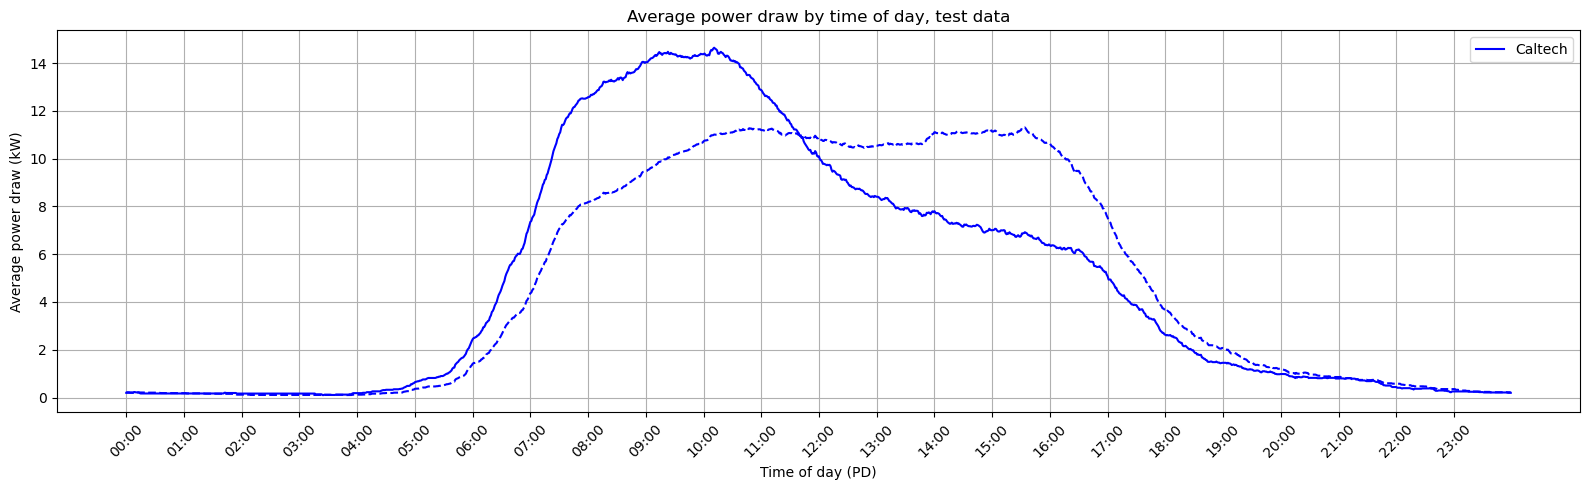

In [8]:
avg_power = plotter_matched(pred_data, choice='done')
avg_power1 = plotter_matched(pred_data, choice='disc')

plt.figure(figsize=(16, 5))
plt.plot(avg_power, label="Caltech", color='blue')
plt.plot(avg_power1,  linestyle='--', color='blue')
plt.xlabel("Time of day (PD)")
plt.ylabel("Average power draw (kW)")
plt.title("Average power draw by time of day, test data")
plt.xticks(
    ticks=np.arange(0, 1440, 60),
    labels=[f"{h:02d}:00" for h in range(24)],
    rotation=45
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
old_load_jpl = plotter_new(jpl_data_pred, 'done')
flat_load_jpl = plotter_new(jpl_data_pred, 'disc')
pred_load_jpl = plotter_new(jpl_data_pred, 'pred')

old_load_cal = plotter_new(cal_data_pred, 'done')
flat_load_cal = plotter_new(cal_data_pred, 'disc')
pred_load_cal = plotter_new(cal_data_pred, 'pred')

old_load_of1 = plotter_new(of1_data_pred, 'done')
flat_load_of1 = plotter_new(of1_data_pred, 'disc')
pred_load_of1 = plotter_new(of1_data_pred, 'pred')

of1_data_pred.head()

,ConnectionTime,SiteID,doneChargingTime,Actual_DisconnectTime,Actual_kWhDelivered,Predicted_DisconnectTime_NN,Predicted_kWhDelivered_NN,stayTime,predStayTime,chargeTime,LoadDisc,LoadDone,LoadPred
12,8.264444,19.0,14.154444,17.060833,27.490,16.284613,30.805628,8.796389,8.020169,5.890000,3.125146,4.667233,3.841020
44,12.000000,19.0,14.025000,17.576667,12.202,17.194347,20.043025,5.576667,5.194347,2.025000,2.188045,6.025679,3.858623
46,6.904444,19.0,11.678056,16.443056,29.497,14.177111,35.461871,9.538611,7.272666,4.773611,3.092379,6.179180,4.876048
61,7.465278,19.0,8.938611,18.305556,3.640,15.279699,6.103022,10.840278,7.814421,1.473333,0.335785,2.470588,0.780995
69,8.117222,19.0,15.076667,19.081111,5.847,15.935702,3.460585,10.963889,7.818480,6.959444,0.533296,0.840153,0.442616


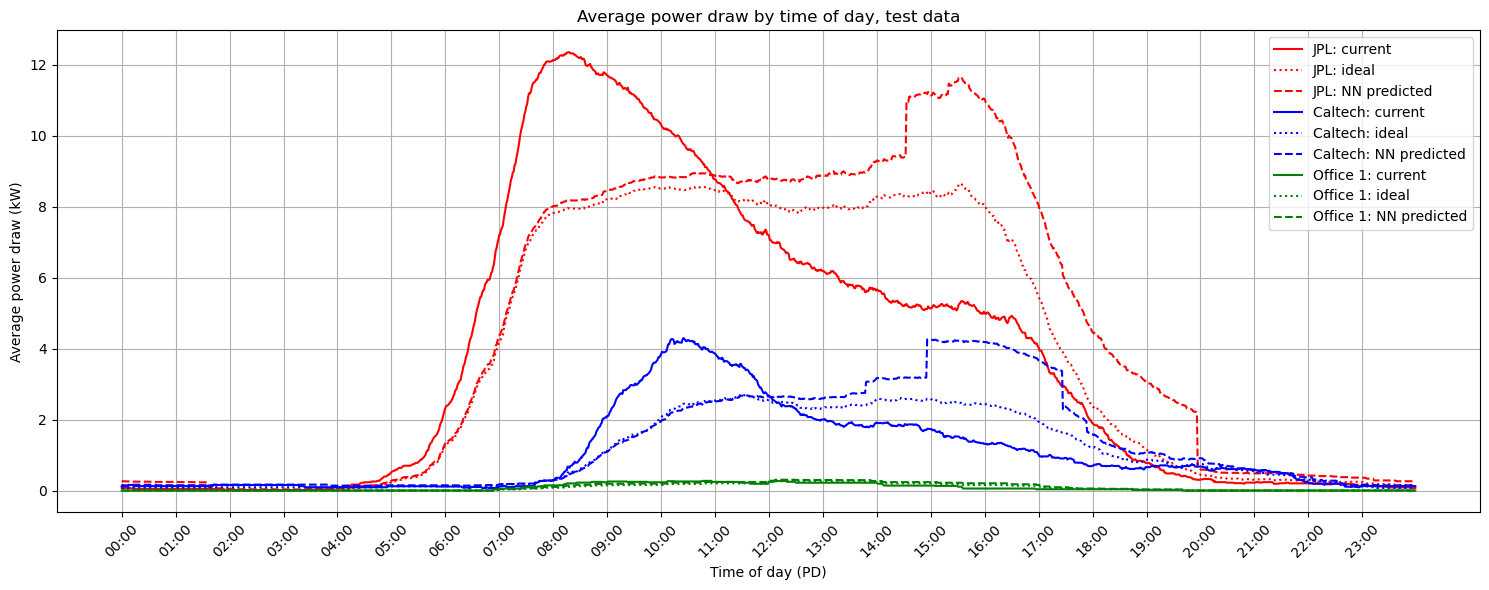

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(old_load_jpl, color='red', label='JPL: current', linewidth=1.5)
plt.plot(flat_load_jpl, linestyle=':', label='JPL: ideal',color='red', linewidth=1.5)
plt.plot(pred_load_jpl, linestyle='--', label='JPL: NN predicted',  color='red', linewidth=1.5)

plt.plot(old_load_cal, color='blue', label='Caltech: current', linewidth=1.5)
plt.plot(flat_load_cal, linestyle=':',label='Caltech: ideal', color='blue', linewidth=1.5)
plt.plot(pred_load_cal, linestyle='--', label='Caltech: NN predicted', color='blue', linewidth=1.5)

plt.plot(old_load_of1, color='green', label='Office 1: current', linewidth=1.5)
plt.plot(flat_load_of1, linestyle=':',label='Office 1: ideal', color='green', linewidth=1.5)
plt.plot(pred_load_of1, linestyle='--', label='Office 1: NN predicted', color='green', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of day (PD)")
plt.ylabel("Average power draw (kW)")
plt.title("Average power draw by time of day, test data")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
def maxpre_processing(file):
    #file inladen
    df = pd.read_csv(file)

    #datum column maken
    df['date_only'] = df['connectionTime'].str.split(' ', n=3).str[1] + ' ' + df['connectionTime'].str.split(' ', n=3).str[2] + ' ' + df['connectionTime'].str.split(' ', n=3).str[3].str.split(' ', n=1).str[0]

    #omzetten tijden
    gmt_tz = pytz.timezone("GMT")
    pst_tz = pytz.timezone("US/Pacific")

    df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')

    df['connectionTime'] = df['connectionTime'].dt.tz_convert(pst_tz)
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(pst_tz)
    df['doneChargingTime'] = df['doneChargingTime'].dt.tz_convert(pst_tz)

    df['LoadDone'] = df['kWhDelivered'] / ((df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600)
    df['LoadDisc'] = df['kWhDelivered'] / ((df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600)

    df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered', 'LoadDone', 'doneChargingTime', 'LoadDisc'])

    df = df.reset_index(drop=True)

    return df

def maxplotter(file, choice):
    minutes_in_day = 24 * 60
    my_dict = {}
    
    keys = list(set(file['date_only'].to_list()))  
    
    for datum in keys:
        energy_per_minute = np.zeros(minutes_in_day)
        for _, row in file[file["date_only"] == datum].iterrows():
            connection = row['connectionTime']
            done = row['doneChargingTime']
            disconnection = row['disconnectTime']
            
            if choice == 'done':
                end = done
                energy = row['LoadDone']

            if choice == 'disc':
                end = disconnection
                energy = row['LoadDisc']
            
            start = connection
            
            if end <= start:
                continue  # Skip invalid sessions

            duration_minutes = int((end - start).total_seconds() / 60)

            for i in range(duration_minutes):
                minute_time = start + timedelta(minutes=i)
                minute_of_day = minute_time.hour * 60 + minute_time.minute
                energy_per_minute[minute_of_day] = energy
                        
        my_dict[datum] = energy_per_minute
    return my_dict   

In [12]:
#display(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"))
energy_file11 = maxplotter(maxpre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"),'done')
energy_file12 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"),'disc')
energy_file21 = maxplotter(maxpre_processing("Data/acndata_sessions 2019_11 till 2020_5 jpl.csv"),'done') 
energy_file22 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 jpl.csv"),'disc')
energy_file31 = maxplotter(maxpre_processing("Data/acndata_sessions 2019_11 till 2020_5 office1.csv"), 'done')
energy_file32 = plotter(pre_processing("Data/acndata_sessions 2019_11 till 2020_5 office1.csv"), 'disc')

C:\Users\chris\AppData\Local\Temp\ipykernel_15308\1012948034.py:3: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\chris\AppData\Local\Temp\ipykernel_15308\3905233878.py:3: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


TypeError: unhashable type: 'dict'

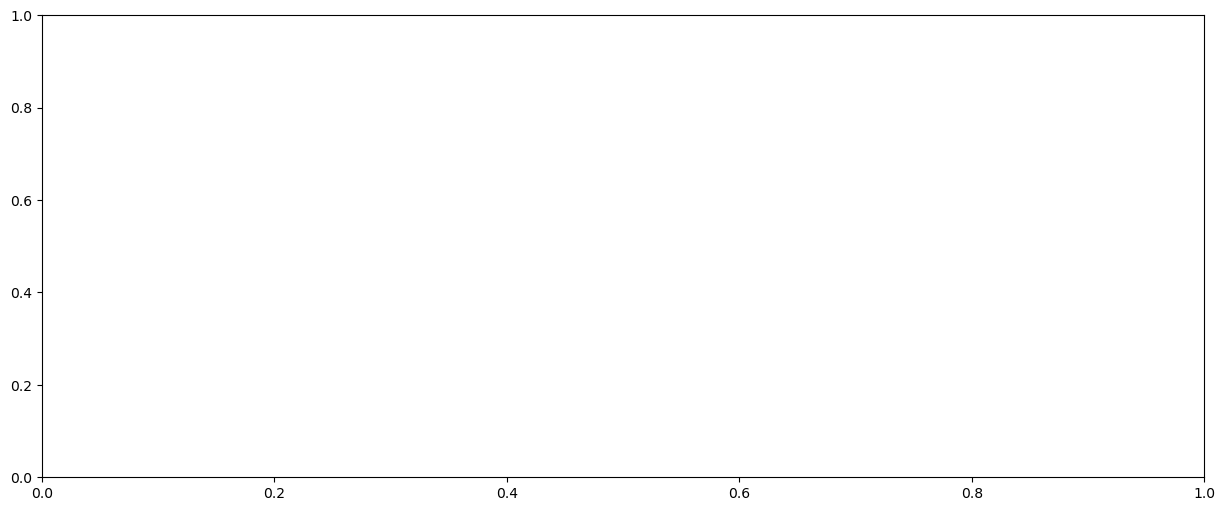

In [13]:
# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(energy_file11, color='blue', label='Caltech', linewidth=1.5)
plt.plot(energy_file12, linestyle='--', color='blue', linewidth=1.5)
plt.plot(energy_file21, color='red', label='JPL', linewidth=1.5)
plt.plot(energy_file22, linestyle='--', color='green', linewidth=1.5)
plt.plot(energy_file31, color='green', label='Office 1', linewidth=1.5)
plt.plot(energy_file32, linestyle='--', color='red', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of day (PD)")
plt.ylabel("Average power draw (kW)")
plt.title("Average power draw by time of day")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()